# Frequency-Severity modelling

 $Claim Frequency = Claim Count / Exposure$
 
 $Claim Severity = Loss / Claim Count$
 
 It is a common actuarial assumption that: Claim Frequency has an over-dispersed Poisson distribution, whilst Claim Severity has a Gamma distribution.
 
 In this notebook we will apply General Linear Modelling (GLM) to estimate claim frequency and severity for auto-insurance data. We will be using the Python statsmodels package, that provides an example on GLM's [here](https://www.statsmodels.org/stable/examples/notebooks/generated/glm.html).


[*Frequency Severity Modelling vs Loss Cost. 2012. Yan, J. 2010 CAS Ratemaking and Product Management  Seminar (CASACT)*](https://www.casact.org/education/rpm/2012/handouts/Session_4738_presentation_1068_0.pdf)

In [256]:
import urllib.request
import shutil
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats
from patsy import dmatrices,dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Load [dataOhlsson](https://cran.r-project.org/web/packages/insuranceData/insuranceData.pdf#Rfn.dataOhlsson.1)

A data frame with 64548 observations on the following 9 variables.
 1. (0:2) agarald - The owners age, between 0 and 99, a numeric vector.
 1. (2:3) kon - The owners age, between 0 and 99, a factor with levelsK M
 1. (3:4) zon - Geographic zone numbered from 1 to 7, in a standard classification of all Swedish parishes, anumeric vector
 1. (4:5) mcklass - MC class, a classification by the so called EV ratio, defined as (Engine power in kW x100) / (Vehicle weight in kg + 75), rounded to the nearest lower integer. The 75 kg represents the average driver weight. The EV ratios are divided into seven classes, a numeric vector
 1. (5:7) fordald - Vehicle age, between 0 and 99, a numeric vector
 1. (7:8) bonuskl - Bonus class, taking values from 1 to 7. 
  - A new driver starts with bonus class 1. For each claim free year the bonus class is increased by 1. 
  - After the first claim the bonus is decreased by  2. The  driver  can  not  return  to  class  7  with  less  than  6  consecutive  claim  free  years,  a numeric vector
 1. (8:16) duration - the number of policy years, a numeric vector
 1. (16:20) antskad - the number of claims, a numeric vector
 1. (20:) skadkost - the claim cost, a numeric vector

- *(n:n) are the columnar positions of the data*
- *data avaliable [here](https://staff.math.su.se/esbj/GLMbook/case.html)*

In [281]:
# read or get file
try: 
    file = open(file_name,'r')
except:
    url = 'https://staff.math.su.se/esbj/GLMbook/mccase.txt'
    file_name='mccase.txt'
    # Download the file from `url` and save it locally under `file_name`:
    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    file = open(file_name,'r')

# load file
dat = list()
for line in file.readlines():
    dat.append([line[:2],line[2:3],line[3:4],line[4:5],line[5:7],line[7:8],line[8:16],line[16:20],str(line[20:]).replace('\n','')])
file.close()
df = pd.DataFrame(dat,columns=['Age','Sex','Geog','EV','VehAge','NCD','PYrs','Claims','Severity'])
df = df.astype({'Age':float,'Sex':'category','Geog':'category','EV':'category',
                'VehAge':int,'NCD':'category','PYrs':float,'Claims':int,'Severity':float}).copy()

# PYrs is the fraction of compelete policy years 
# there are some policies with 0.0 duration (1/365 = 0.00274 = 1 day)
# set these to 1 day
df.loc[df['PYrs']==0.0,'PYrs'] = 1.0/365.0

print(df.dtypes)

Age          float64
Sex         category
Geog        category
EV          category
VehAge         int32
NCD         category
PYrs         float64
Claims         int32
Severity     float64
dtype: object


***EDA***

- low number of claims and frequency (1% freq)

In [282]:
df.describe()

,Age,VehAge,PYrs,Claims,Severity
count,64548.000000,64548.000000,64548.000000,64548.000000,64548.000000
mean,42.416062,12.540063,1.010759,0.010798,264.017785
std,12.980960,9.727445,1.307356,0.107323,4694.693604
min,0.000000,0.000000,0.002740,0.000000,0.000000
25%,31.000000,5.000000,0.463014,0.000000,0.000000
50%,44.000000,12.000000,0.827397,0.000000,0.000000
75%,52.000000,16.000000,1.000000,0.000000,0.000000
max,92.000000,99.000000,31.339730,2.000000,365347.000000


In [283]:
claims = df.loc[df['Claims']!=0]
claims.describe()

,Age,VehAge,PYrs,Claims,Severity
count,670.000000,670.000000,670.000000,670.000000,670.000000
mean,35.476119,7.965672,1.579415,1.040299,25435.552239
std,12.851056,6.768896,2.983317,0.196805,38539.415033
min,16.000000,0.000000,0.002740,1.000000,16.000000
25%,25.000000,2.000000,0.430137,1.000000,3031.500000
50%,30.000000,7.000000,0.790411,1.000000,9015.000000
75%,47.000000,12.000000,1.497945,1.000000,29304.500000
max,68.000000,55.000000,31.167120,2.000000,365347.000000


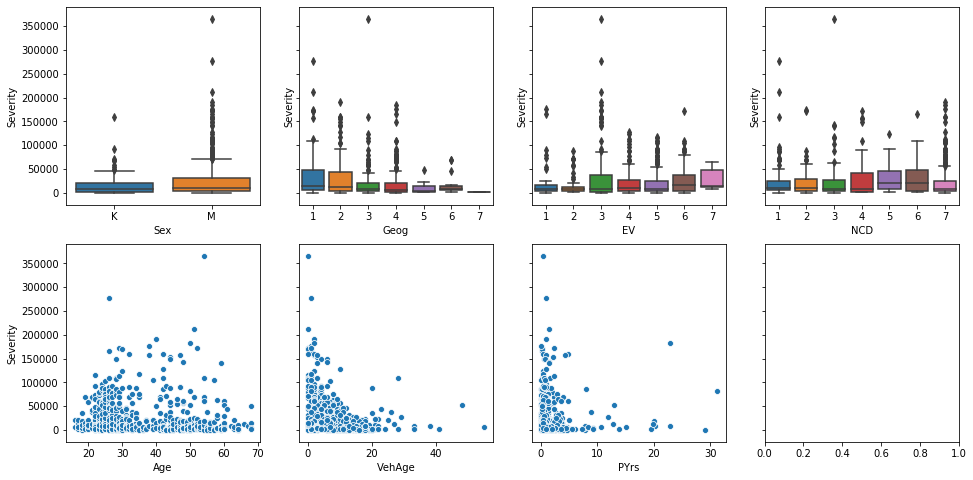

In [284]:
fig,axs=plt.subplots(2,4,figsize=(16,8),sharey=True)
for col,ax in zip(df.select_dtypes(include='category').columns,axs.flatten()):
    sns.boxplot(x=col,y='Severity',data=claims,ax=ax)

for col,ax in zip(['Age','VehAge','PYrs'],axs.flatten()[4:]):
    sns.scatterplot(x=col,y='Severity',data=claims,ax=ax)

# Modelling
- StatsModels (SM) uses patsy [formula notation](https://www.statsmodels.org/devel/example_formulas.html).
- This includes: [notation for categorical variables ](https://www.statsmodels.org/devel/contrasts.html), setting [reference/base levels](https://stackoverflow.com/a/22439820/4538066), [encoding options](https://www.statsmodels.org/devel/contrasts.html), and [operators](https://www.statsmodels.org/devel/example_formulas.html#categorical-variables).

In [368]:
# single claim frequency indicator
df['Claim'] = (df['Claims']>=1).astype(int)

# train-test splits stratifies on claims
train,test = train_test_split(df,test_size=0.3,random_state=1990,stratify=df['Claims']).copy()

### $Claim Frequency$

For predicting the occurence of a single claim (i.e. binary classification) one can use the Binomial distribution (a.k.a Bernoulli trial or coin-toss experiment).

When predicting claim counts or frequency, $Y$, a model that prodices Poisson distributed outputs is required. For instance, a Poisson model is suitable for estimating the number of insurance claims per policy per year, or to estimate the number of car crashes per month. 

The key components and assumptions of a Poisson distributed process are: 
 1. event occurence is independant of other events. 
 1. events occur within a fixed period of time.
 1. the mean a variance of the distribution are equal e.g. $mu(X) = Var(X) = λ$
 
[*STAT 504: Poisson Distribution*](https://online.stat.psu.edu/stat504/node/57/)


If the mean and variance are unequal the distribution is said to be over-disperesed (var > mean) or under-dispersed (var < mean). Over-dispersion commonly arises in data where there are large number of zero's (a.k.a [zero-inflated](https://en.wikipedia.org/wiki/Zero-inflated_model)).

In the case of zero-inflated data, it is "*A sound practice is to estimate both Poisson and negative binomial models.*" [*Cameron, 2013*](http://faculty.econ.ucdavis.edu/faculty/cameron/racd2/). Also see this practical example for [beverage consumption in python](https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/)

In GLM's, link-functions are applied in order to make the mean outcome (prediction) fit to some linear model of input variables from other distributions. "*A natural fit for count variables that follow the Poisson or negative binomial distribution is the log link. The log link exponentiates the linear predictors. It does not log transform the outcome variable.*" - [*Count Models: Understanding the Log Link Function,TAF*](https://www.theanalysisfactor.com/count-models-understanding-the-log-link-function/)

For more information on link-functions see also [here](https://bookdown.org/castillo_sam_d/Exam-PA-Study-Manual/glms-for-classification.html#link-functions).

Lastly, for any form of count prediction model one can also set an offset or exposure. An offset, if it is known, is applied in order to account for the relative differences in exposure time for of a set of inputs. For example, in insurance claims we might expect to see more claims on an account with 20 years worth of annual policies compared to an account with 1 single policy year. Offsets account for the relative exposure|surface area|population size|etc and is akin to the relative frequency of occurence ($Claims/years$). See these intuititve SO answers [here](https://stats.stackexchange.com/questions/232666/should-i-use-an-offset-for-my-poisson-glm) and [here](https://github.com/statsmodels/statsmodels/issues/1486#issuecomment-40945831)

In [286]:
Image(url= "https://i0.wp.com/www.theanalysisfactor.com/wp-content/uploads/2016/12/StataCombos-CM2-Blog-JM.png?w=535&ssl=1")

In [287]:
# Mean & Variance
mu = df.Claims.mean()
var = np.mean([abs(x - mu)**2 for x in df.Claims])
print(f'mu =  {mu:.4f}\nvar = {var:.4f}')

mu =  0.0108
var = 0.0115


In [365]:
# print('+'.join(train.columns))
expr = "Claims ~ Age+Sex+Geog+EV+VehAge+NCD+ np.log(PYrs)"
#expr = "Claims ~ Age+C(Sex)+C(Geog, Treatment(reference=3))+EV+VehAge+NCD"

FreqPoisson = smf.glm(formula=expr,
                      data=train,
                      #offset=np.log(train['PYrs']),
                      family=sm.families.Poisson(link=sm.families.links.log())).fit()

FreqNegBin = smf.glm(formula=expr,
                      data=train,
                      #offset=np.log(train['PYrs']),
                      family=sm.families.NegativeBinomial(link=sm.families.links.log())).fit()

In [366]:
print(FreqPoisson.summary())
print(FreqNegBin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Claims   No. Observations:                45183
Model:                            GLM   Df Residuals:                    45160
Model Family:                 Poisson   Df Model:                           22
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2434.1
Date:                Sun, 19 Apr 2020   Deviance:                       3918.6
Time:                        20:29:26   Pearson chi2:                 5.47e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.6080      0.291     -5.517   

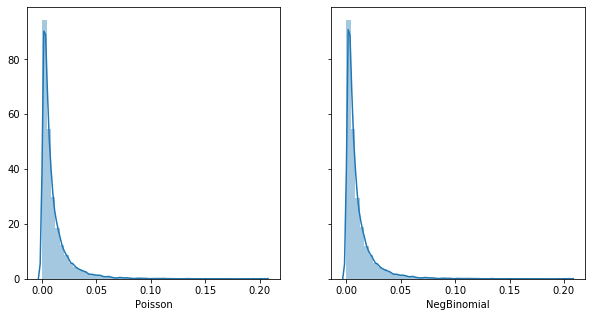

In [367]:
fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
sns.distplot(FreqPoisson.predict(test),ax=axs[0],axlabel='Poisson')
sns.distplot(FreqNegBin.predict(test),ax=axs[1],axlabel='NegBinomial');

In [ ]:
test['Fnb'] = FreqNegBin.predict(test)
test['Fpo'] = FreqPoisson.predict(test)

In [371]:
test.loc[test['Claim']==1]

,Age,Sex,Geog,EV,VehAge,NCD,PYrs,Claims,Severity,Claim,Fnb,Fpo
2039,21.0,M,2,2,19,1,0.432877,1,11110.0,1,0.014502,0.014414
18459,33.0,M,1,5,2,7,1.246575,1,74300.0,1,0.102585,0.102581
3822,23.0,M,1,4,7,7,0.515068,1,26957.0,1,0.053872,0.053892
56458,57.0,M,4,3,15,7,2.000000,1,737.0,1,0.003754,0.003745
39351,47.0,M,4,3,19,3,2.000000,1,829.0,1,0.001999,0.002002
...,...,...,...,...,...,...,...,...,...,...,...,...
52230,54.0,M,3,6,0,7,0.745205,1,497.0,1,0.025953,0.025758
40679,48.0,M,2,4,20,2,0.534247,1,50.0,1,0.001819,0.001826
14588,30.0,M,1,3,3,2,0.504110,1,4339.0,1,0.028565,0.028921
1965,21.0,M,1,1,18,2,1.000000,1,5000.0,1,0.023212,0.023362
